In [4]:
import tarfile
import os

# Function to extract a .tgz dataset
def extract_tgz(file_path, extracted_path):
    if not os.path.exists(extracted_path):
        os.makedirs(extracted_path)
    with tarfile.open(file_path, "r:gz") as tar:
        tar.extractall(path=extracted_path)
        # Paths for dataset extraction
file_path = "/content/cora.tgz"  # Path to the .tgz file
extracted_path = "/content/cora_dataset/"  # Path where the dataset will be extracted

# Extract the dataset
extract_tgz(file_path, extracted_path)
print("Extraction completed. Files are located in:", extracted_path)

# Check the contents of the extracted path
print("Contents of the extracted path:", os.listdir(extracted_path))
# Check the `cora` subdirectory
cora_dir = os.path.join(extracted_path, "cora")
if os.path.exists(cora_dir):
    print("Contents of the 'cora' directory:", os.listdir(cora_dir))
else:
    print("The 'cora' directory does not exist.")

Extraction completed. Files are located in: /content/cora_dataset/
Contents of the extracted path: ['cora']
Contents of the 'cora' directory: ['cora.content', 'cora.cites', 'README']


In [5]:
import networkx as nx
import os

# Function to load the citation graph from the dataset
def load_citation_graph(cites_file):
    G = nx.DiGraph()  # Directed graph because citations represent direction
    with open(cites_file, 'r') as f:
        for line in f:
            source, target = line.strip().split()
            G.add_edge(int(source), int(target))
    return G

# Path to the `cora.cites` file
cora_dir = "/content/cora_dataset/cora"
cites_file = os.path.join(cora_dir, "cora.cites")

# Load the graph
G = load_citation_graph(cites_file)

# Print basic graph information
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph has 2708 nodes and 5429 edges.


In [6]:
def compute_all_centralities(G):
    # Compute all centrality measures
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    eigenvector_centrality = nx.eigenvector_centrality(G)

    # Organize centrality measures into a dictionary
    centrality_measures = {
        "Degree Centrality": degree_centrality,
        "Closeness Centrality": closeness_centrality,
        "Betweenness Centrality": betweenness_centrality,
        "Eigenvector Centrality": eigenvector_centrality,
    }

    # Print the top 5 nodes for each centrality measure
    for measure_name, centrality in centrality_measures.items():
        print(f"\nTop 5 nodes by {measure_name}:")
        top_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:5]
        for node, value in top_nodes:
            print(f"Node {node}: {value:.4f}")
compute_all_centralities(G)


Top 5 nodes by Degree Centrality:
Node 35: 0.0624
Node 6213: 0.0292
Node 1365: 0.0273
Node 3229: 0.0240
Node 910: 0.0170

Top 5 nodes by Closeness Centrality:
Node 1107067: 0.0070
Node 1153811: 0.0068
Node 66982: 0.0068
Node 39210: 0.0067
Node 1050679: 0.0067

Top 5 nodes by Betweenness Centrality:
Node 1272: 0.0013
Node 13686: 0.0012
Node 6184: 0.0012
Node 85688: 0.0010
Node 887: 0.0010

Top 5 nodes by Eigenvector Centrality:
Node 126927: 0.4848
Node 103543: 0.3924
Node 645897: 0.3592
Node 644093: 0.2915
Node 646286: 0.2853


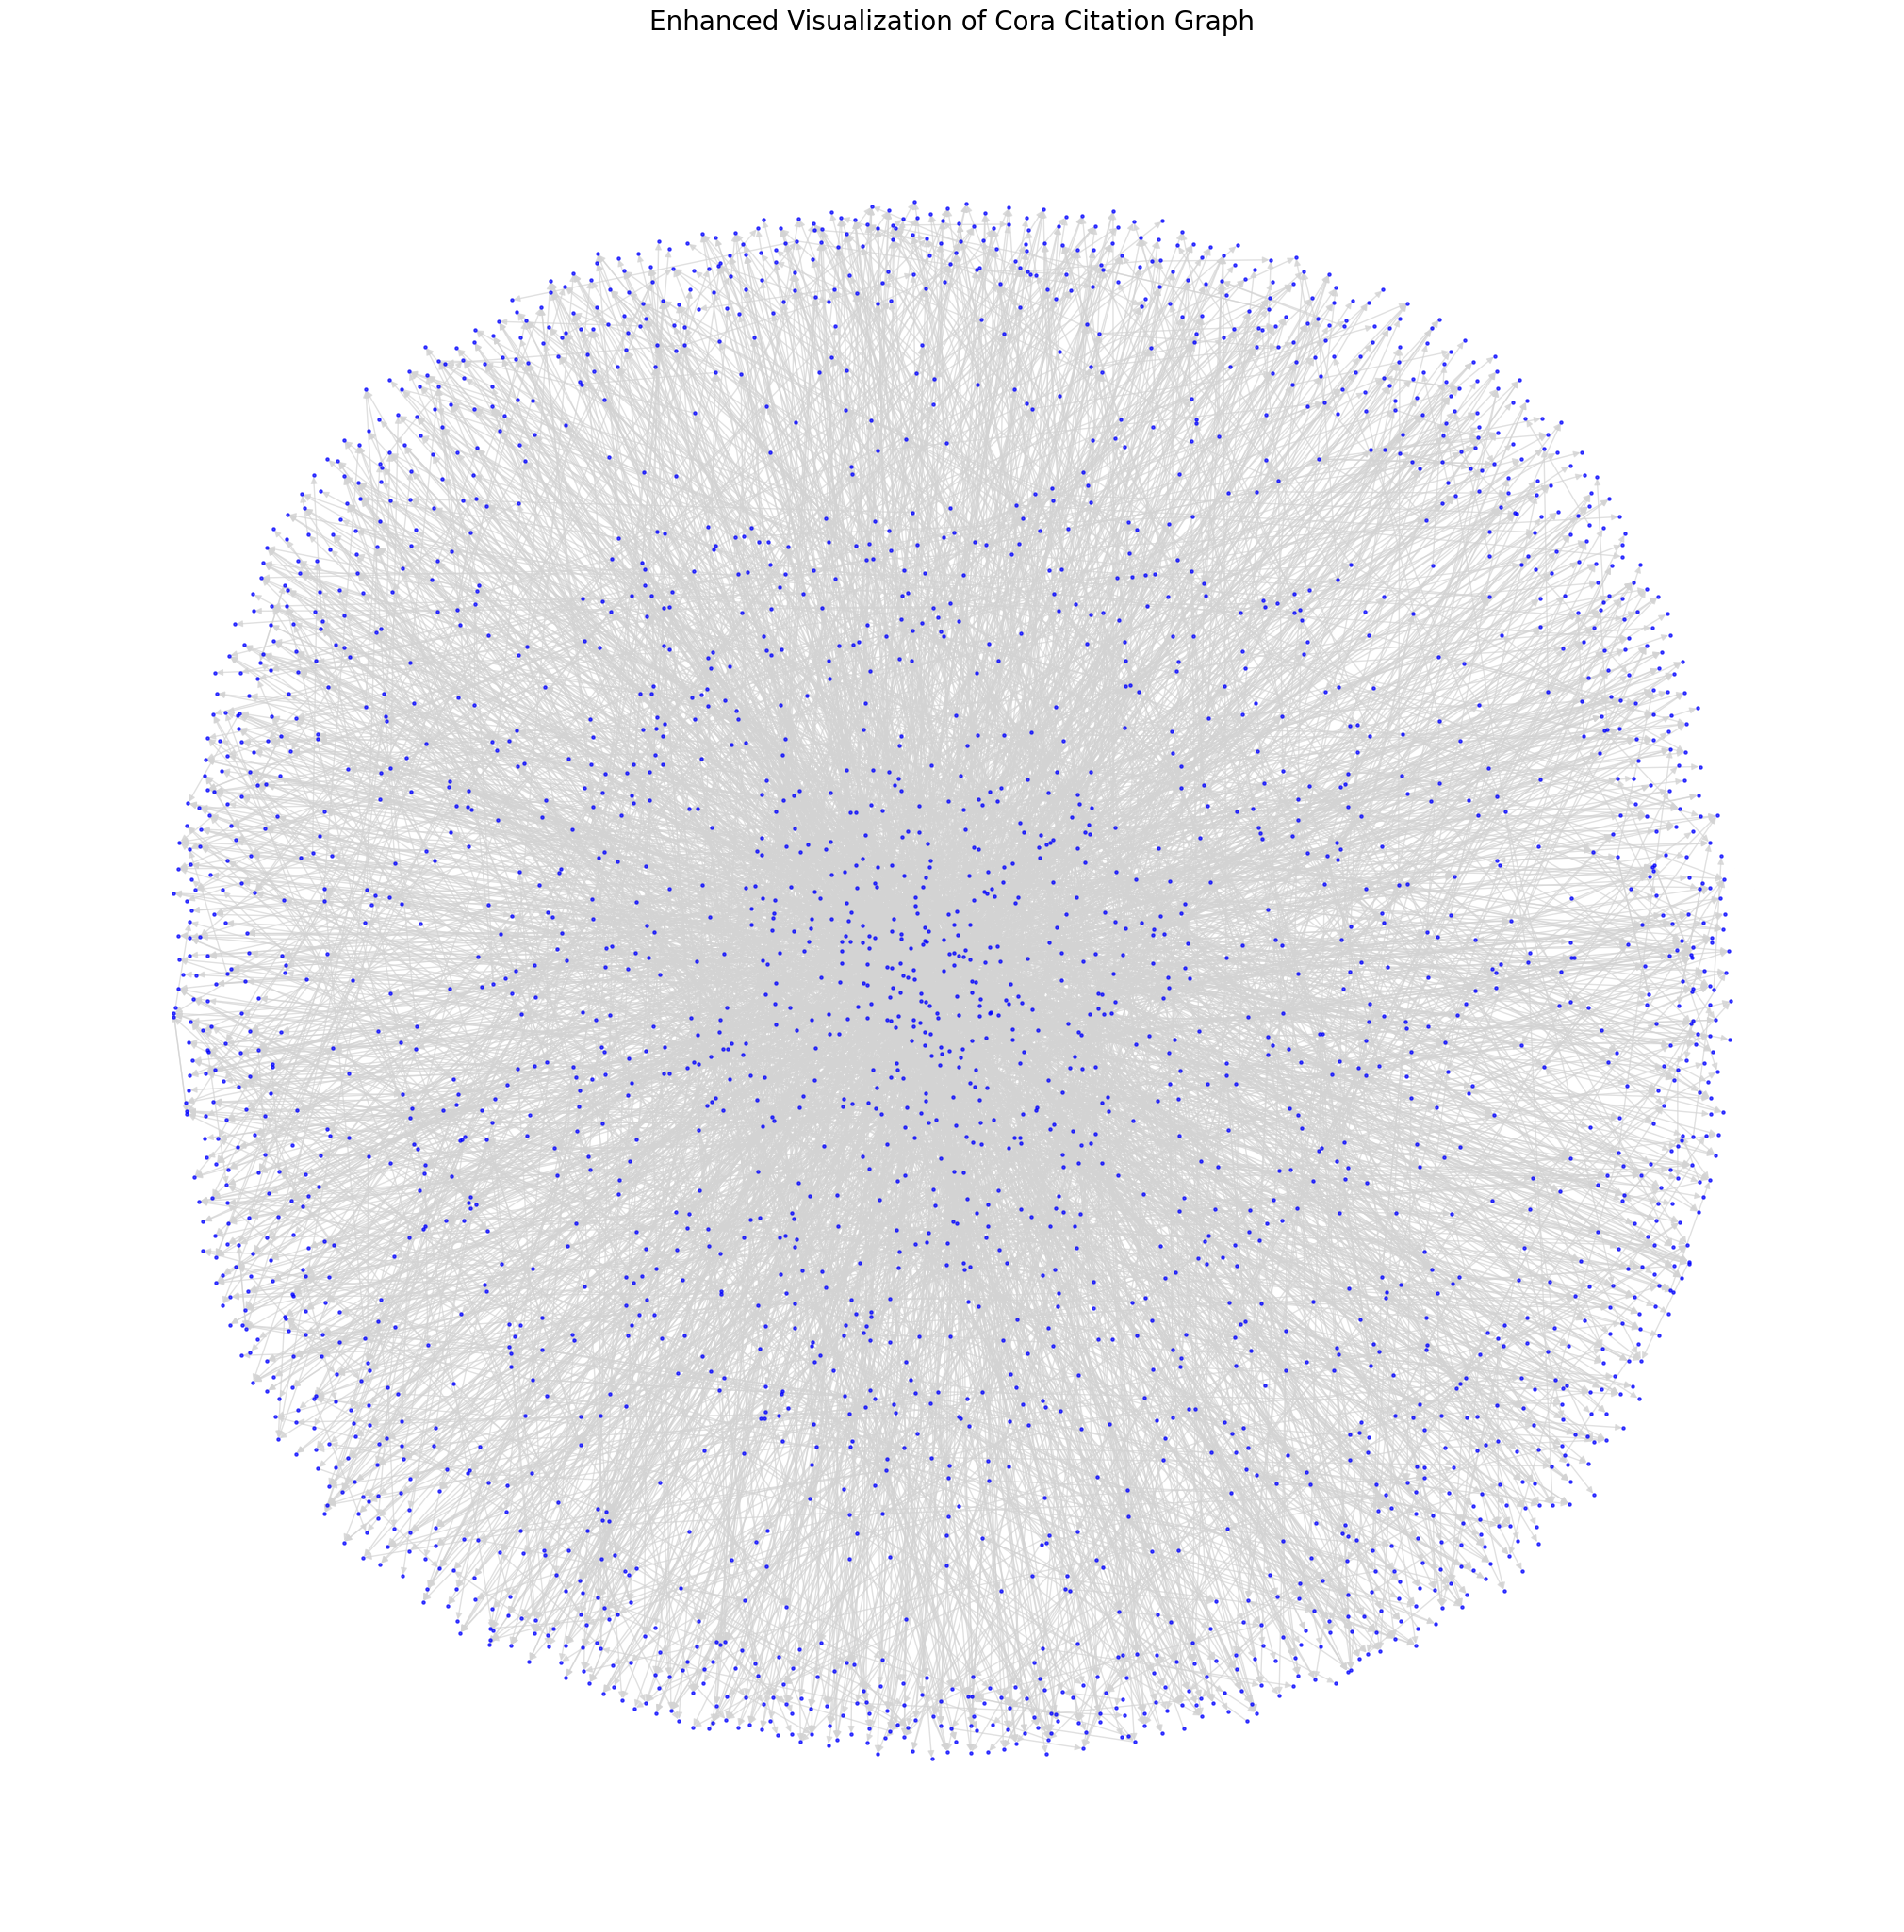

In [7]:
import matplotlib.pyplot as plt
import networkx as nx

# Function to visualize the graph with an enhanced spring layout
def visualize_graph_enhanced(G):
    plt.figure(figsize=(20, 20))  # Larger figure for better visualization
    pos = nx.spring_layout(G, k=0.1, iterations=50)  # k controls spacing; iterations improve convergence
    nx.draw(
        G,
        pos,
        node_size=5,
        node_color="blue",   # Color of the nodes
        edge_color="lightgray",  # Edge color
        alpha=0.7,           # Transparency for better aesthetics
        with_labels=False    # Disable labels for a clean look
    )
    plt.title("Enhanced Visualization of Cora Citation Graph", fontsize=20)
    plt.show()

# Visualize the graph with the enhanced layout
visualize_graph_enhanced(G)


# **Node2vec**

In [8]:
!pip install node2vec
!pip install torch torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.0 MB/s eta 0:00:00


In [9]:
from node2vec import Node2Vec

# function to generate node embeddings
def generate_node2vec_embeddings_optimized(G, dimensions=64, walk_length=20, num_walks=100, workers=8):
    """
    Generate node embeddings using node2vec with optimized parameters.

    Parameters:
        G: networkx graph
        dimensions: int, size of the embedding vectors
        walk_length: int, length of each random walk
        num_walks: int, number of random walks per node
        workers: int, number of parallel workers (CPU cores)

    Returns:
        node_embeddings: dict, mapping of node to embedding
    """
    # Convert node IDs to strings
    G_str = nx.relabel_nodes(G, {node: str(node) for node in G.nodes()})

    # Initialize Node2Vec with optimized parameters
    node2vec = Node2Vec(
        G_str,
        dimensions=dimensions,
        walk_length=walk_length,
        num_walks=num_walks,
        workers=workers,
        quiet=True                # Suppress verbose output for speed
    )

    # Fit model to generate embeddings
    model = node2vec.fit(window=10, min_count=1, batch_words=8)

    # Generate embeddings
    node_embeddings = {int(node): model.wv[node] for node in G_str.nodes()}  # Convert back to original node IDs
    return node_embeddings

# Generate node embeddings with optimized settings
node_embeddings = generate_node2vec_embeddings_optimized(G)
print(f"Generated embeddings for {len(node_embeddings)} nodes.")


Generated embeddings for 2708 nodes.


# **GAT**

In [21]:
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GATConv
from torch_geometric.utils import add_self_loops
from torch_geometric.transforms import NormalizeFeatures
import torch
import torch.nn as nn
import torch.nn.functional as F

# Load Cora dataset with feature normalization
dataset = Planetoid(root="/tmp/Cora", name="Cora", transform=NormalizeFeatures())
data = dataset[0]

# Add self-loops to the edge index
data.edge_index, _ = add_self_loops(data.edge_index)

class GAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=8, dropout=0.6)
        self.conv2 = GATConv(hidden_channels * 8, hidden_channels, heads=4, dropout=0.6)
        self.conv3 = GATConv(hidden_channels * 4, out_channels, heads=1, dropout=0.6)
        self.residual = nn.Linear(in_channels, out_channels)  # Match dimensions for residual connection
        self.dropout = nn.Dropout(0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x1 = F.elu(self.conv1(x, edge_index))
        x2 = F.elu(self.conv2(self.dropout(x1), edge_index))
        x3 = self.conv3(self.dropout(x2), edge_index)
        x_residual = self.residual(x)  # Transform x to match x3's shape
        return x3 + x_residual  # Residual connection

# Initialize model, optimizer, and loss function
model = GAT(in_channels=dataset.num_node_features, hidden_channels=64, out_channels=dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=1e-3)
loss_fn = nn.CrossEntropyLoss()

# Training parameters
best_loss = float("inf")
patience = 50
counter = 0

# Training loop
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # Early stopping logic
    if loss.item() < best_loss:
        best_loss = loss.item()
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping triggered.")
        break

    if (epoch + 1) % 10 == 0:  # Print every 10 epochs
        print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")

# Evaluate the model
model.eval()
with torch.no_grad():
    out = model(data)
    pred = out[data.test_mask].argmax(dim=1)
    acc = (pred == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
    print(f"Test Accuracy: {acc:.4f}")


Epoch 10, Loss: 1.7957
Epoch 20, Loss: 1.4873
Epoch 30, Loss: 0.9155
Epoch 40, Loss: 0.6398
Epoch 50, Loss: 0.5953
Epoch 60, Loss: 0.4893
Epoch 70, Loss: 0.4884
Epoch 80, Loss: 0.4850
Epoch 90, Loss: 0.4056
Epoch 100, Loss: 0.4484
Epoch 110, Loss: 0.3583
Epoch 120, Loss: 0.3976
Epoch 130, Loss: 0.4294
Epoch 140, Loss: 0.5216
Epoch 150, Loss: 0.4356
Epoch 160, Loss: 0.3974
Epoch 170, Loss: 0.3612
Epoch 180, Loss: 0.3965
Epoch 190, Loss: 0.4174
Epoch 200, Loss: 0.4087
Epoch 210, Loss: 0.4464
Epoch 220, Loss: 0.3702
Epoch 230, Loss: 0.4023
Epoch 240, Loss: 0.3972
Epoch 250, Loss: 0.5075
Epoch 260, Loss: 0.4411
Epoch 270, Loss: 0.3237
Early stopping triggered.
Test Accuracy: 0.8190


# **RGNN**

In [20]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops


###############################################################################
# 0) Reproducibility: Set Seeds
###############################################################################
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(42)

###############################################################################
# 1) Load the Cora Dataset
###############################################################################
dataset = Planetoid(root="/tmp/Cora", name="Cora", transform=NormalizeFeatures())
data = dataset[0]

# add self-loops
data.edge_index, _ = add_self_loops(data.edge_index)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

train_mask = data.train_mask
val_mask = data.val_mask
test_mask = data.test_mask

print(f"Dataset: {dataset.name}")
print(f"Number of Nodes: {data.num_nodes}")
print(f"Number of Features: {dataset.num_node_features}")
print(f"Number of Classes: {dataset.num_classes}")

###############################################################################
# 2) A Single-Layer RGNN with Multi-Step (T) GRU Updates
###############################################################################
class MultiStepRGNNLayer(MessagePassing):
    """
    A single RGNN layer that runs T iterative message-passing steps:

      For t in 1..T:
        h_i(t+1) = GRUCell( sum_{j in N(i)} h_j(t),  h_i(t) )

    We use 'add' to sum neighbor embeddings.
    """
    def __init__(self, hidden_dim, T=2):
        super().__init__(aggr='add')  # Summation aggregator
        self.rnn = nn.GRUCell(hidden_dim, hidden_dim)
        self.T = T

    def forward(self, x, edge_index):
        # x: [num_nodes, hidden_dim]
        # We'll do T repeated message-passing steps
        for _ in range(self.T):
            x = self.propagate(edge_index, x=x)
        return x

    def message(self, x_j):
        # x_j: neighbor (j) features
        return x_j

    def update(self, aggr_out, x):
        # aggr_out: sum of neighbors' hidden states
        # x: the old hidden state of the node
        return self.rnn(aggr_out, x)

###############################################################################
# 3) A Simple RGNN Model (One Layer, Multi-Step)
###############################################################################
class MultiStepRGNN(nn.Module):
    """
    This model:
      1) Projects input features to hidden_dim
      2) Applies one RGNNLayer that does T steps of GRU-based updates
      3) Projects to output logits
    """
    def __init__(self, in_feats, hidden_dim, out_feats, T=2, dropout=0.5):
        super().__init__()
        self.lin_in = nn.Linear(in_feats, hidden_dim)
        self.rgnn = MultiStepRGNNLayer(hidden_dim, T=T)
        self.lin_out = nn.Linear(hidden_dim, out_feats)
        self.dropout = dropout

    def forward(self, x, edge_index):
        # 1) Linear projection
        x = self.lin_in(x)   # [num_nodes, hidden_dim]
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # 2) RGNN with T multi-step updates
        x = self.rgnn(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # 3) Output layer (logits)
        x = self.lin_out(x)
        return x

###############################################################################
# 4) Instantiate and Train
###############################################################################
model = MultiStepRGNN(
    in_feats=dataset.num_node_features,
    hidden_dim=64,   # Larger hidden dimension
    out_feats=dataset.num_classes,
    T=2,             # 2 iterative updates
    dropout=0.5
).to(device)

optimizer = Adam(model.parameters(), lr=0.0009, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

best_val_loss = float('inf')
best_model_state = None
patience = 50
counter = 0

max_epochs = 300

for epoch in range(1, max_epochs + 1):
    model.train()
    optimizer.zero_grad()

    out = model(data.x, data.edge_index)
    train_loss = criterion(out[train_mask], data.y[train_mask])
    train_loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_out = model(data.x, data.edge_index)
        val_loss = criterion(val_out[val_mask], data.y[val_mask])

    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        counter = 0
        best_model_state = model.state_dict()
    else:
        counter += 1

    if counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

# Restore best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)

###############################################################################
# 5) Test Evaluation
###############################################################################
model.eval()
with torch.no_grad():
    logits = model(data.x, data.edge_index)
    test_pred = logits[test_mask].argmax(dim=1)
    test_acc = (test_pred == data.y[test_mask]).sum().item() / test_mask.sum().item()

print(f"Test Accuracy: {test_acc:.4f}")


Dataset: Cora
Number of Nodes: 2708
Number of Features: 1433
Number of Classes: 7
Epoch 10, Train Loss: 1.9129, Val Loss: 1.9393
Epoch 20, Train Loss: 1.8656, Val Loss: 1.9048
Epoch 30, Train Loss: 1.7851, Val Loss: 1.8426
Epoch 40, Train Loss: 1.6825, Val Loss: 1.7548
Epoch 50, Train Loss: 1.5264, Val Loss: 1.6434
Epoch 60, Train Loss: 1.3784, Val Loss: 1.5045
Epoch 70, Train Loss: 1.1817, Val Loss: 1.3473
Epoch 80, Train Loss: 0.9680, Val Loss: 1.2014
Epoch 90, Train Loss: 0.7961, Val Loss: 1.0925
Epoch 100, Train Loss: 0.6141, Val Loss: 0.9900
Epoch 110, Train Loss: 0.5217, Val Loss: 0.9152
Epoch 120, Train Loss: 0.4351, Val Loss: 0.8620
Epoch 130, Train Loss: 0.3491, Val Loss: 0.8279
Epoch 140, Train Loss: 0.2986, Val Loss: 0.8084
Epoch 150, Train Loss: 0.2362, Val Loss: 0.7998
Epoch 160, Train Loss: 0.2282, Val Loss: 0.8067
Epoch 170, Train Loss: 0.1975, Val Loss: 0.7898
Epoch 180, Train Loss: 0.1891, Val Loss: 0.7976
Epoch 190, Train Loss: 0.1548, Val Loss: 0.7882
Epoch 200, Trai